In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import albumentations as A
from efficientnet_pytorch import EfficientNet

In [2]:
import random
import torch.backends.cudnn as cudnn

seed = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

In [3]:
seed_everything(seed)

# Data load

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="2"

In [5]:
train_total = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [6]:
train_total

,uid,img_path,disease,disease_code
0,10000,train_imgs/10000.jpg,시설포도노균병,1
1,10001,train_imgs/10001.jpg,시설포도노균병,1
2,10002,train_imgs/10002.jpg,시설포도노균병반응,2
3,10003,train_imgs/10003.jpg,축과병,4
4,10004,train_imgs/10004.jpg,시설포도노균병,1
...,...,...,...,...
245,10245,train_imgs/10245.jpg,시설포도노균병반응,2
246,10246,train_imgs/10246.jpg,시설포도탄저병반응,6
247,10247,train_imgs/10247.jpg,시설포도노균병,1
248,10248,train_imgs/10248.jpg,시설포도노균병반응,2


###  데이터 불균형 제거

In [7]:
train_total['disease'].unique()

array(['시설포도노균병', '시설포도노균병반응', '축과병', '정상', '시설포도탄저병', '일소피해',
       '시설포도탄저병반응'], dtype=object)

In [8]:
train_total['disease'].value_counts() 

정상           106
시설포도노균병       46
시설포도노균병반응     30
일소피해          29
축과병           17
시설포도탄저병       12
시설포도탄저병반응     10
Name: disease, dtype: int64

In [9]:
# disease = train_total['disease'].values
print(train_total[train_total['disease'].isin(['정상'])][:40].index)
print(train_total[train_total['disease'].isin(['시설포도노균병'])][:10].index)
print(train_total[train_total['disease'].isin(['시설포도노균병반응'])][:5].index)
print(train_total[train_total['disease'].isin(['일소피해'])][:5].index)

Int64Index([ 5,  6,  8, 10, 11, 12, 13, 16, 22, 24, 25, 26, 28, 35, 36, 38, 39,
            40, 42, 43, 46, 47, 48, 49, 50, 52, 57, 58, 61, 62, 64, 66, 67, 70,
            72, 73, 75, 76, 81, 82],
           dtype='int64')
Int64Index([0, 1, 4, 18, 30, 34, 41, 51, 56, 59], dtype='int64')
Int64Index([2, 7, 14, 27, 31], dtype='int64')
Int64Index([15, 20, 23, 29, 45], dtype='int64')


In [10]:
# 정상, 시설 포도, 시설포도노균병반응, 일소피해
train = train_total.drop(index=[ 5,  6,  8, 10, 11, 12, 13, 16, 22, 24, 25, 26, 28, 35, 36, 38, 39,
            40, 42, 43, 46, 47, 48, 49, 50, 52, 57, 58, 61, 62, 64, 66, 67, 70,
            72, 73, 75, 76, 81, 82])
# train = train.drop(index=[0, 1, 4, 18, 30, 34, 41, 51, 56, 59])
train = train.drop(index=[ 34, 41, 51, 56, 59])
# train = train.drop(index=[2, 7, 14, 27, 31])
# train = train.drop(index=[15, 20, 23, 29, 45])

In [11]:
train['disease'].value_counts() 

정상           66
시설포도노균병      41
시설포도노균병반응    30
일소피해         29
축과병          17
시설포도탄저병      12
시설포도탄저병반응    10
Name: disease, dtype: int64

In [12]:
train

,uid,img_path,disease,disease_code
0,10000,train_imgs/10000.jpg,시설포도노균병,1
1,10001,train_imgs/10001.jpg,시설포도노균병,1
2,10002,train_imgs/10002.jpg,시설포도노균병반응,2
3,10003,train_imgs/10003.jpg,축과병,4
4,10004,train_imgs/10004.jpg,시설포도노균병,1
...,...,...,...,...
245,10245,train_imgs/10245.jpg,시설포도노균병반응,2
246,10246,train_imgs/10246.jpg,시설포도탄저병반응,6
247,10247,train_imgs/10247.jpg,시설포도노균병,1
248,10248,train_imgs/10248.jpg,시설포도노균병반응,2


In [13]:
test

,uid,img_path
0,20000,test_imgs/20000.jpg
1,20001,test_imgs/20001.jpg
2,20002,test_imgs/20002.jpg
3,20003,test_imgs/20003.jpg
4,20004,test_imgs/20004.jpg
...,...,...
4745,24745,test_imgs/24745.jpg
4746,24746,test_imgs/24746.jpg
4747,24747,test_imgs/24747.jpg
4748,24748,test_imgs/24748.jpg


In [14]:
device = torch.device("cuda:0")
batch_size = 64
dropout_rate = 0.1
class_n = len(train_total['disease_code'].unique())
learning_rate = 1e-4
epochs = 100
save_path = 'models/model_100_v3.pt'

# augmentation

In [15]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, ImageCompression,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomCrop, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize,
    ChannelShuffle, LongestMaxSize, HueSaturationValue, ISONoise
)


albumentations_transform = A.Compose([
#     Blur(),
#     RandomBrightnessContrast(),
#     HueSaturationValue(),
#     RandomCrop(224, 224),
    A.OneOf([
        A.HorizontalFlip(p=0.2),       
        A.RandomRotate90(p=0.3),
        A.VerticalFlip(p=0.5)            
    ], p=1),
    A.OneOf([
        A.MotionBlur(p=0.5),
        A.OpticalDistortion(p=0.5),
        A.GaussNoise(p=0.5)                 
    ], p=1),
],p=1.)

val_transform =  A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=1),       
        A.RandomRotate90(p=1),
        A.VerticalFlip(p=1)            
    ], p=1)  
])



In [16]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None,transformer=None, mode='train'):
        self.mode = mode
        self.files = files
        self.transformer = transformer
        if mode == 'train':
            self.labels = labels
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        if self.mode == 'train':
            img = cv2.imread('data/train_imgs/'+self.files[i])
            img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32)/255
            if self.transformer != None:
                img = self.transformer(image=img)
                img = np.transpose(img["image"], (2,0,1))
            else:
                img = np.transpose(img, (2,0,1))
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'label' : torch.tensor(self.labels[i], dtype=torch.long)
            }
        else:
            img = cv2.imread('data/test_imgs/'+self.files[i])
            img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
            img = img.astype(np.float32)/255
            img = np.transpose(img, (2,0,1))
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
            }

In [17]:
train = train.iloc[:180]
val = train.iloc[-180:]

In [18]:
train_dataset = CustomDataset(train['img_path'].str.split('/').str[-1].values, train['disease_code'].values, transformer=None)
# val_dataset = CustomDataset(val['img_path'].str.split('/').str[-1].values, val['disease_code'].values, transformer=albumentations_transform)
val_dataset = CustomDataset(val['img_path'].str.split('/').str[-1].values, val['disease_code'].values, transformer=None)
test_dataset = CustomDataset(test['img_path'].str.split('/').str[-1], labels=None, mode='test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

In [19]:
# print(train['img_path'].str.split('/').str[-1].values)

In [20]:
# from torchvision import transforms
# import torchvision.transforms.functional as F

# for i in range(100):
#   sample, _, = train_dataset[0]

# # print("torchvision time/sample: {} ms".format(total_time*10))

# plt.figure(figsize=(10, 10))
# plt.imshow(transforms.ToPILImage()(torch.FloatTensor(sample)))
# plt.show()

### 모델 학습

In [21]:
# class CNN_Model(nn.Module):
#     def __init__(self, class_n, rate=0.1):
#         super(CNN_Model, self).__init__()
#         # self.model = models.resnet50(pretrained=True)
#         self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=class_n, advprop=True)
#         self.dropout = nn.Dropout(rate)
#         self.output_layer = nn.Linear(in_features=1000, out_features=class_n, bias=True)
    
#     def forward(self, inputs):
#         output = self.output_layer(self.dropout(self.model(inputs)))
#         return output

# model = CNN_Model(class_n).to(device)


In [22]:
# model = EfficientNet.from_pretrained('efficientnet-b5', num_classes=class_n, advprop=True)
model = EfficientNet.from_pretrained('efficientnet-b5', num_classes=class_n, advprop=True)
model._dropout.p = dropout_rate

model = model.to(device)
# model

Loaded pretrained weights for efficientnet-b5


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

In [24]:
def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(img)
            loss = criterion(output, label)
            
        return loss

In [25]:
loss_plot, val_loss_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    scheduler.step(total_val_loss/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)
        print(f"## _{epoch+1}_Model Save")

3it [00:21,  7.16s/it, Epoch=1, Loss=1.862679, Total Loss=1.903781]
3it [00:13,  4.57s/it, Epoch=1, Val Loss=1.900474, Total Val Loss=1.896730]


## _1_Model Save


3it [00:13,  4.55s/it, Epoch=2, Loss=1.565243, Total Loss=1.645745]
3it [00:12,  4.26s/it, Epoch=2, Val Loss=1.819170, Total Val Loss=1.825171]


## _2_Model Save


3it [00:13,  4.56s/it, Epoch=3, Loss=1.422827, Total Loss=1.438273]
3it [00:12,  4.27s/it, Epoch=3, Val Loss=1.786867, Total Val Loss=1.750716]


## _3_Model Save


3it [00:13,  4.54s/it, Epoch=4, Loss=1.238235, Total Loss=1.242126]
3it [00:12,  4.25s/it, Epoch=4, Val Loss=1.587851, Total Val Loss=1.655065]


## _4_Model Save


3it [00:13,  4.57s/it, Epoch=5, Loss=0.911009, Total Loss=1.014772]
3it [00:12,  4.25s/it, Epoch=5, Val Loss=1.514956, Total Val Loss=1.557022]


## _5_Model Save


3it [00:13,  4.56s/it, Epoch=6, Loss=0.842018, Total Loss=0.874300]
3it [00:12,  4.26s/it, Epoch=6, Val Loss=1.422156, Total Val Loss=1.450287]


## _6_Model Save


3it [00:13,  4.59s/it, Epoch=7, Loss=0.633450, Total Loss=0.687160]
3it [00:12,  4.26s/it, Epoch=7, Val Loss=1.319708, Total Val Loss=1.334252]


## _7_Model Save


3it [00:13,  4.56s/it, Epoch=8, Loss=0.493213, Total Loss=0.533514]
3it [00:12,  4.27s/it, Epoch=8, Val Loss=1.207975, Total Val Loss=1.216014]


## _8_Model Save


3it [00:13,  4.58s/it, Epoch=9, Loss=0.386604, Total Loss=0.398975]
3it [00:12,  4.26s/it, Epoch=9, Val Loss=1.104652, Total Val Loss=1.095266]


## _9_Model Save


3it [00:13,  4.55s/it, Epoch=10, Loss=0.278192, Total Loss=0.315353]
3it [00:12,  4.25s/it, Epoch=10, Val Loss=1.034262, Total Val Loss=0.979101]


## _10_Model Save


3it [00:13,  4.51s/it, Epoch=11, Loss=0.230992, Total Loss=0.235895]
3it [00:12,  4.23s/it, Epoch=11, Val Loss=0.944245, Total Val Loss=0.871238]


## _11_Model Save


3it [00:13,  4.52s/it, Epoch=12, Loss=0.155346, Total Loss=0.172329]
3it [00:12,  4.22s/it, Epoch=12, Val Loss=0.859963, Total Val Loss=0.769321]


## _12_Model Save


3it [00:13,  4.54s/it, Epoch=13, Loss=0.111370, Total Loss=0.146084]
3it [00:12,  4.26s/it, Epoch=13, Val Loss=0.755386, Total Val Loss=0.671340]


## _13_Model Save


3it [00:13,  4.53s/it, Epoch=14, Loss=0.084230, Total Loss=0.096564]
3it [00:12,  4.23s/it, Epoch=14, Val Loss=0.507163, Total Val Loss=0.569151]


## _14_Model Save


3it [00:13,  4.54s/it, Epoch=15, Loss=0.072175, Total Loss=0.063707]
3it [00:12,  4.23s/it, Epoch=15, Val Loss=0.500122, Total Val Loss=0.493858]


## _15_Model Save


3it [00:13,  4.55s/it, Epoch=16, Loss=0.042075, Total Loss=0.046907]
3it [00:12,  4.24s/it, Epoch=16, Val Loss=0.283519, Total Val Loss=0.411426]


## _16_Model Save


3it [00:13,  4.54s/it, Epoch=17, Loss=0.026097, Total Loss=0.037628]
3it [00:12,  4.25s/it, Epoch=17, Val Loss=0.339785, Total Val Loss=0.353467]


## _17_Model Save


3it [00:13,  4.53s/it, Epoch=18, Loss=0.038638, Total Loss=0.041083]
3it [00:12,  4.25s/it, Epoch=18, Val Loss=0.229048, Total Val Loss=0.290542]


## _18_Model Save


3it [00:13,  4.55s/it, Epoch=19, Loss=0.019571, Total Loss=0.032759]
3it [00:12,  4.24s/it, Epoch=19, Val Loss=0.258418, Total Val Loss=0.244729]


## _19_Model Save


3it [00:13,  4.55s/it, Epoch=20, Loss=0.026155, Total Loss=0.035045]
3it [00:12,  4.24s/it, Epoch=20, Val Loss=0.254706, Total Val Loss=0.201397]


## _20_Model Save


3it [00:13,  4.54s/it, Epoch=21, Loss=0.039603, Total Loss=0.033295]
3it [00:12,  4.25s/it, Epoch=21, Val Loss=0.113604, Total Val Loss=0.158121]


## _21_Model Save


3it [00:13,  4.54s/it, Epoch=22, Loss=0.022565, Total Loss=0.021232]
3it [00:12,  4.22s/it, Epoch=22, Val Loss=0.138208, Total Val Loss=0.133124]


## _22_Model Save


3it [00:13,  4.51s/it, Epoch=23, Loss=0.028630, Total Loss=0.022172]
3it [00:12,  4.20s/it, Epoch=23, Val Loss=0.092439, Total Val Loss=0.110057]


## _23_Model Save


3it [00:13,  4.54s/it, Epoch=24, Loss=0.023047, Total Loss=0.018652]
3it [00:12,  4.24s/it, Epoch=24, Val Loss=0.063310, Total Val Loss=0.089548]


## _24_Model Save


3it [00:13,  4.54s/it, Epoch=25, Loss=0.014801, Total Loss=0.018358]
3it [00:12,  4.23s/it, Epoch=25, Val Loss=0.055005, Total Val Loss=0.072815]


## _25_Model Save


3it [00:13,  4.53s/it, Epoch=26, Loss=0.014703, Total Loss=0.016796]
3it [00:12,  4.19s/it, Epoch=26, Val Loss=0.060708, Total Val Loss=0.060835]


## _26_Model Save


3it [00:13,  4.52s/it, Epoch=27, Loss=0.011781, Total Loss=0.013147]
3it [00:12,  4.23s/it, Epoch=27, Val Loss=0.062177, Total Val Loss=0.049784]


## _27_Model Save


3it [00:13,  4.54s/it, Epoch=28, Loss=0.013422, Total Loss=0.013449]
3it [00:12,  4.24s/it, Epoch=28, Val Loss=0.030116, Total Val Loss=0.038028]


## _28_Model Save


3it [00:13,  4.52s/it, Epoch=29, Loss=0.017179, Total Loss=0.016058]
3it [00:12,  4.22s/it, Epoch=29, Val Loss=0.020682, Total Val Loss=0.030806]


## _29_Model Save


3it [00:13,  4.54s/it, Epoch=30, Loss=0.023331, Total Loss=0.016615]
3it [00:12,  4.23s/it, Epoch=30, Val Loss=0.019043, Total Val Loss=0.024970]


## _30_Model Save


3it [00:13,  4.57s/it, Epoch=31, Loss=0.023704, Total Loss=0.013750]
3it [00:12,  4.25s/it, Epoch=31, Val Loss=0.022830, Total Val Loss=0.020701]


## _31_Model Save


3it [00:13,  4.58s/it, Epoch=32, Loss=0.013081, Total Loss=0.011299]
3it [00:12,  4.26s/it, Epoch=32, Val Loss=0.009679, Total Val Loss=0.016454]


## _32_Model Save


3it [00:13,  4.56s/it, Epoch=33, Loss=0.011388, Total Loss=0.011425]
3it [00:12,  4.24s/it, Epoch=33, Val Loss=0.007849, Total Val Loss=0.013669]


## _33_Model Save


3it [00:13,  4.53s/it, Epoch=34, Loss=0.012235, Total Loss=0.011148]
3it [00:12,  4.23s/it, Epoch=34, Val Loss=0.008739, Total Val Loss=0.011431]


## _34_Model Save


3it [00:13,  4.54s/it, Epoch=35, Loss=0.013647, Total Loss=0.011862]
3it [00:12,  4.24s/it, Epoch=35, Val Loss=0.014362, Total Val Loss=0.009956]


## _35_Model Save


3it [00:13,  4.54s/it, Epoch=36, Loss=0.010968, Total Loss=0.008573]
3it [00:12,  4.22s/it, Epoch=36, Val Loss=0.007651, Total Val Loss=0.008229]


## _36_Model Save


3it [00:13,  4.54s/it, Epoch=37, Loss=0.007000, Total Loss=0.015097]
3it [00:12,  4.24s/it, Epoch=37, Val Loss=0.010493, Total Val Loss=0.007055]


## _37_Model Save


3it [00:13,  4.54s/it, Epoch=38, Loss=0.006904, Total Loss=0.010774]
3it [00:12,  4.23s/it, Epoch=38, Val Loss=0.008551, Total Val Loss=0.006047]


## _38_Model Save


3it [00:13,  4.54s/it, Epoch=39, Loss=0.008572, Total Loss=0.006608]
3it [00:12,  4.26s/it, Epoch=39, Val Loss=0.007411, Total Val Loss=0.005331]


## _39_Model Save


3it [00:13,  4.54s/it, Epoch=40, Loss=0.008911, Total Loss=0.008392]
3it [00:12,  4.22s/it, Epoch=40, Val Loss=0.006224, Total Val Loss=0.004804]


## _40_Model Save


3it [00:13,  4.54s/it, Epoch=41, Loss=0.022748, Total Loss=0.011671]
3it [00:12,  4.25s/it, Epoch=41, Val Loss=0.003455, Total Val Loss=0.004198]


## _41_Model Save


3it [00:13,  4.53s/it, Epoch=42, Loss=0.009383, Total Loss=0.008758]
3it [00:12,  4.24s/it, Epoch=42, Val Loss=0.005210, Total Val Loss=0.003889]


## _42_Model Save


3it [00:13,  4.54s/it, Epoch=43, Loss=0.007433, Total Loss=0.007016]
3it [00:12,  4.22s/it, Epoch=43, Val Loss=0.002894, Total Val Loss=0.003381]


## _43_Model Save


3it [00:13,  4.53s/it, Epoch=44, Loss=0.005191, Total Loss=0.006273]
3it [00:12,  4.25s/it, Epoch=44, Val Loss=0.003807, Total Val Loss=0.003118]


## _44_Model Save


3it [00:13,  4.55s/it, Epoch=45, Loss=0.008334, Total Loss=0.008664]
3it [00:12,  4.25s/it, Epoch=45, Val Loss=0.003836, Total Val Loss=0.002875]


## _45_Model Save


3it [00:13,  4.57s/it, Epoch=46, Loss=0.012588, Total Loss=0.009128]
3it [00:12,  4.27s/it, Epoch=46, Val Loss=0.002211, Total Val Loss=0.002549]


## _46_Model Save


3it [00:13,  4.54s/it, Epoch=47, Loss=0.011986, Total Loss=0.007597]
3it [00:12,  4.23s/it, Epoch=47, Val Loss=0.002177, Total Val Loss=0.002366]


## _47_Model Save


3it [00:13,  4.55s/it, Epoch=48, Loss=0.008103, Total Loss=0.008225]
3it [00:12,  4.29s/it, Epoch=48, Val Loss=0.002084, Total Val Loss=0.002213]


## _48_Model Save


3it [00:13,  4.55s/it, Epoch=49, Loss=0.014075, Total Loss=0.010181]
3it [00:12,  4.19s/it, Epoch=49, Val Loss=0.001778, Total Val Loss=0.002064]


## _49_Model Save


3it [00:13,  4.50s/it, Epoch=50, Loss=0.007096, Total Loss=0.005997]
3it [00:12,  4.17s/it, Epoch=50, Val Loss=0.001766, Total Val Loss=0.001948]


## _50_Model Save


3it [00:13,  4.49s/it, Epoch=51, Loss=0.010497, Total Loss=0.010085]
3it [00:12,  4.19s/it, Epoch=51, Val Loss=0.001442, Total Val Loss=0.001819]


## _51_Model Save


3it [00:13,  4.52s/it, Epoch=52, Loss=0.009400, Total Loss=0.008341]
3it [00:12,  4.24s/it, Epoch=52, Val Loss=0.001639, Total Val Loss=0.001734]


## _52_Model Save


3it [00:13,  4.54s/it, Epoch=53, Loss=0.006320, Total Loss=0.006339]
3it [00:12,  4.23s/it, Epoch=53, Val Loss=0.001848, Total Val Loss=0.001664]


## _53_Model Save


3it [00:13,  4.55s/it, Epoch=54, Loss=0.011100, Total Loss=0.009403]
3it [00:12,  4.22s/it, Epoch=54, Val Loss=0.001418, Total Val Loss=0.001563]


## _54_Model Save


3it [00:13,  4.55s/it, Epoch=55, Loss=0.007077, Total Loss=0.009740]
3it [00:12,  4.24s/it, Epoch=55, Val Loss=0.001538, Total Val Loss=0.001502]


## _55_Model Save


3it [00:13,  4.57s/it, Epoch=56, Loss=0.008414, Total Loss=0.007863]
3it [00:12,  4.26s/it, Epoch=56, Val Loss=0.001379, Total Val Loss=0.001429]


## _56_Model Save


3it [00:13,  4.52s/it, Epoch=57, Loss=0.006688, Total Loss=0.007005]
3it [00:12,  4.24s/it, Epoch=57, Val Loss=0.001506, Total Val Loss=0.001383]


## _57_Model Save


3it [00:13,  4.55s/it, Epoch=58, Loss=0.008060, Total Loss=0.007008]
3it [00:12,  4.24s/it, Epoch=58, Val Loss=0.001306, Total Val Loss=0.001310]


## _58_Model Save


3it [00:13,  4.53s/it, Epoch=59, Loss=0.004694, Total Loss=0.004742]
3it [00:12,  4.26s/it, Epoch=59, Val Loss=0.001298, Total Val Loss=0.001260]


## _59_Model Save


3it [00:13,  4.55s/it, Epoch=60, Loss=0.003264, Total Loss=0.004304]
3it [00:12,  4.27s/it, Epoch=60, Val Loss=0.001292, Total Val Loss=0.001208]


## _60_Model Save


3it [00:13,  4.56s/it, Epoch=61, Loss=0.008721, Total Loss=0.006338]
3it [00:12,  4.24s/it, Epoch=61, Val Loss=0.001046, Total Val Loss=0.001138]


## _61_Model Save


3it [00:13,  4.55s/it, Epoch=62, Loss=0.005380, Total Loss=0.004135]
3it [00:12,  4.23s/it, Epoch=62, Val Loss=0.001047, Total Val Loss=0.001091]


## _62_Model Save


3it [00:13,  4.56s/it, Epoch=63, Loss=0.007034, Total Loss=0.007417]
3it [00:12,  4.24s/it, Epoch=63, Val Loss=0.001069, Total Val Loss=0.001048]


## _63_Model Save


3it [00:13,  4.52s/it, Epoch=64, Loss=0.007688, Total Loss=0.008435]
3it [00:12,  4.25s/it, Epoch=64, Val Loss=0.001095, Total Val Loss=0.001035]


## _64_Model Save


3it [00:13,  4.56s/it, Epoch=65, Loss=0.005670, Total Loss=0.005133]
3it [00:12,  4.25s/it, Epoch=65, Val Loss=0.001020, Total Val Loss=0.001019]


## _65_Model Save


3it [00:13,  4.54s/it, Epoch=66, Loss=0.003632, Total Loss=0.004515]
3it [00:12,  4.25s/it, Epoch=66, Val Loss=0.000973, Total Val Loss=0.001002]


## _66_Model Save


3it [00:13,  4.56s/it, Epoch=67, Loss=0.007197, Total Loss=0.005440]
3it [00:12,  4.24s/it, Epoch=67, Val Loss=0.001215, Total Val Loss=0.001003]
3it [00:13,  4.53s/it, Epoch=68, Loss=0.006073, Total Loss=0.008429]
3it [00:12,  4.22s/it, Epoch=68, Val Loss=0.000893, Total Val Loss=0.000968]


## _68_Model Save


3it [00:13,  4.49s/it, Epoch=69, Loss=0.005824, Total Loss=0.004577]
3it [00:12,  4.22s/it, Epoch=69, Val Loss=0.000927, Total Val Loss=0.000958]


## _69_Model Save


3it [00:13,  4.51s/it, Epoch=70, Loss=0.009061, Total Loss=0.005864]
3it [00:12,  4.26s/it, Epoch=70, Val Loss=0.001024, Total Val Loss=0.000948]


## _70_Model Save


3it [00:13,  4.55s/it, Epoch=71, Loss=0.003161, Total Loss=0.005014]
3it [00:12,  4.24s/it, Epoch=71, Val Loss=0.000872, Total Val Loss=0.000921]


## _71_Model Save


3it [00:13,  4.53s/it, Epoch=72, Loss=0.002261, Total Loss=0.003876]
3it [00:12,  4.23s/it, Epoch=72, Val Loss=0.000989, Total Val Loss=0.000903]


## _72_Model Save


3it [00:13,  4.54s/it, Epoch=73, Loss=0.007965, Total Loss=0.007145]
3it [00:12,  4.25s/it, Epoch=73, Val Loss=0.000854, Total Val Loss=0.000880]


## _73_Model Save


3it [00:13,  4.55s/it, Epoch=74, Loss=0.005398, Total Loss=0.003680]
3it [00:12,  4.23s/it, Epoch=74, Val Loss=0.000815, Total Val Loss=0.000866]


## _74_Model Save


3it [00:13,  4.53s/it, Epoch=75, Loss=0.004279, Total Loss=0.008352]
3it [00:12,  4.24s/it, Epoch=75, Val Loss=0.000822, Total Val Loss=0.000850]


## _75_Model Save


3it [00:13,  4.53s/it, Epoch=76, Loss=0.003591, Total Loss=0.003550]
3it [00:12,  4.23s/it, Epoch=76, Val Loss=0.000937, Total Val Loss=0.000841]


## _76_Model Save


3it [00:13,  4.51s/it, Epoch=77, Loss=0.002363, Total Loss=0.005287]
3it [00:12,  4.18s/it, Epoch=77, Val Loss=0.000804, Total Val Loss=0.000825]


## _77_Model Save


3it [00:13,  4.52s/it, Epoch=78, Loss=0.002399, Total Loss=0.003130]
3it [00:12,  4.23s/it, Epoch=78, Val Loss=0.000812, Total Val Loss=0.000796]


## _78_Model Save


3it [00:13,  4.55s/it, Epoch=79, Loss=0.002892, Total Loss=0.003655]
3it [00:12,  4.24s/it, Epoch=79, Val Loss=0.000780, Total Val Loss=0.000770]


## _79_Model Save


3it [00:13,  4.52s/it, Epoch=80, Loss=0.003359, Total Loss=0.003097]
3it [00:12,  4.23s/it, Epoch=80, Val Loss=0.000613, Total Val Loss=0.000732]


## _80_Model Save


3it [00:13,  4.53s/it, Epoch=81, Loss=0.006318, Total Loss=0.003965]
3it [00:12,  4.26s/it, Epoch=81, Val Loss=0.000714, Total Val Loss=0.000711]


## _81_Model Save


3it [00:13,  4.52s/it, Epoch=82, Loss=0.004168, Total Loss=0.003730]
3it [00:12,  4.24s/it, Epoch=82, Val Loss=0.000790, Total Val Loss=0.000683]


## _82_Model Save


3it [00:13,  4.51s/it, Epoch=83, Loss=0.004608, Total Loss=0.004431]
3it [00:12,  4.20s/it, Epoch=83, Val Loss=0.000647, Total Val Loss=0.000649]


## _83_Model Save


3it [00:13,  4.54s/it, Epoch=84, Loss=0.002250, Total Loss=0.003245]
3it [00:12,  4.23s/it, Epoch=84, Val Loss=0.000649, Total Val Loss=0.000624]


## _84_Model Save


3it [00:13,  4.57s/it, Epoch=85, Loss=0.002753, Total Loss=0.004751]
3it [00:12,  4.23s/it, Epoch=85, Val Loss=0.000651, Total Val Loss=0.000604]


## _85_Model Save


3it [00:13,  4.55s/it, Epoch=86, Loss=0.001891, Total Loss=0.003780]
3it [00:12,  4.27s/it, Epoch=86, Val Loss=0.000611, Total Val Loss=0.000590]


## _86_Model Save


3it [00:13,  4.56s/it, Epoch=87, Loss=0.003716, Total Loss=0.003490]
3it [00:12,  4.23s/it, Epoch=87, Val Loss=0.000634, Total Val Loss=0.000583]


## _87_Model Save


3it [00:13,  4.54s/it, Epoch=88, Loss=0.003627, Total Loss=0.003139]
3it [00:12,  4.23s/it, Epoch=88, Val Loss=0.000536, Total Val Loss=0.000566]


## _88_Model Save


3it [00:13,  4.53s/it, Epoch=89, Loss=0.005225, Total Loss=0.004036]
3it [00:12,  4.23s/it, Epoch=89, Val Loss=0.000509, Total Val Loss=0.000551]


## _89_Model Save


3it [00:13,  4.54s/it, Epoch=90, Loss=0.004833, Total Loss=0.004219]
3it [00:12,  4.22s/it, Epoch=90, Val Loss=0.000564, Total Val Loss=0.000539]


## _90_Model Save


3it [00:13,  4.54s/it, Epoch=91, Loss=0.003873, Total Loss=0.003671]
3it [00:12,  4.24s/it, Epoch=91, Val Loss=0.000569, Total Val Loss=0.000526]


## _91_Model Save


3it [00:13,  4.54s/it, Epoch=92, Loss=0.004059, Total Loss=0.002463]
3it [00:12,  4.23s/it, Epoch=92, Val Loss=0.000514, Total Val Loss=0.000512]


## _92_Model Save


3it [00:13,  4.54s/it, Epoch=93, Loss=0.003163, Total Loss=0.003906]
3it [00:12,  4.24s/it, Epoch=93, Val Loss=0.000441, Total Val Loss=0.000499]


## _93_Model Save


3it [00:13,  4.54s/it, Epoch=94, Loss=0.002078, Total Loss=0.002329]
3it [00:12,  4.24s/it, Epoch=94, Val Loss=0.000512, Total Val Loss=0.000495]


## _94_Model Save


3it [00:13,  4.55s/it, Epoch=95, Loss=0.003290, Total Loss=0.002486]
3it [00:12,  4.23s/it, Epoch=95, Val Loss=0.000447, Total Val Loss=0.000483]


## _95_Model Save


3it [00:13,  4.53s/it, Epoch=96, Loss=0.002473, Total Loss=0.004181]
3it [00:12,  4.24s/it, Epoch=96, Val Loss=0.000502, Total Val Loss=0.000480]


## _96_Model Save


3it [00:13,  4.51s/it, Epoch=97, Loss=0.013342, Total Loss=0.006813]
3it [00:12,  4.19s/it, Epoch=97, Val Loss=0.000430, Total Val Loss=0.000473]


## _97_Model Save


3it [00:13,  4.52s/it, Epoch=98, Loss=0.002993, Total Loss=0.002245]
3it [00:12,  4.21s/it, Epoch=98, Val Loss=0.000478, Total Val Loss=0.000476]
3it [00:13,  4.52s/it, Epoch=99, Loss=0.009928, Total Loss=0.004466]
3it [00:12,  4.20s/it, Epoch=99, Val Loss=0.000480, Total Val Loss=0.000477]
3it [00:13,  4.51s/it, Epoch=100, Loss=0.004916, Total Loss=0.003219]
3it [00:12,  4.22s/it, Epoch=100, Val Loss=0.000402, Total Val Loss=0.000476]


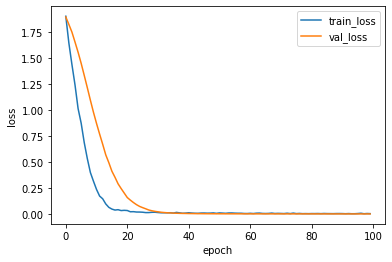

In [26]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [27]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    training = False
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        with torch.no_grad():
            output = model(img)
        output = torch.tensor(torch.argmax(output, axis=-1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

In [28]:
preds = predict(test_dataloader)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
75it [05:37,  4.50s/it]


In [29]:
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:,1] = preds

In [30]:
submission.to_csv('cls_baseline_100_v3.csv', index=False)